# 基于RFM模型的K-means聚类分析

  前面已经根据RFM模型将用户分为标准的八类，但RFM是业务规则，划分标准主观，且每个维度独立，忽略相关性。而K-means是数据驱动，能发现自然聚类的群体，处理多个变量之间的复杂关系。所以采用K-means聚类对数据进行挖掘，结果与RFM模型相互验证补充，进行更全面的用户画像。
  K-means聚类分群更精准、能发现隐藏模式、可处理多维度，本次分析目的为**深度用户洞察、寻求增长机会、高度定制化营销策略。**

## 一、导入必需的库

In [1]:
# 导入所需的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示（如果需要）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置绘图风格
plt.style.use('ggplot')
%matplotlib inline

## 二、加载数据

In [2]:
# 读取数据
df = pd.read_csv(r'D:\DA_Projects\data\e-commerce_user_order_data.csv',engine='python',encoding='gbk')

## 三、数据预览

In [3]:
# 查看数据前5行
df.head()

,用户ID,用户出生日期,性别,婚姻状况,文化程度,下单时间,订单ID,交易金额
0,6414111,1991-8-24,男,已婚,本科,2020-1-1 17:41,1000595826,402.765811
1,6516117,1983-7-21,女,已婚,博士,2021-10-15 22:47,1000610643,545.273062
2,6714112,1986-6-21,女,已婚,博士,2020-11-22 9:45,1001934364,256.716973
3,5311117,1978-5-25,女,未婚,大专,2021-3-26 11:53,1007749907,275.547080
4,4316113,1979-8-1,男,未婚,大专,2021-7-10 18:59,1007770144,1023.500156


In [4]:
# 查看数据基本信息：列名、非空值数量、数据类型
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   用户ID    5000 non-null   int64  
 1   用户出生日期  5000 non-null   object 
 2   性别      5000 non-null   object 
 3   婚姻状况    5000 non-null   object 
 4   文化程度    5000 non-null   object 
 5   下单时间    5000 non-null   object 
 6   订单ID    5000 non-null   int64  
 7   交易金额    5000 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 312.6+ KB


In [5]:
# 查看数值型数据的统计描述
df.describe()

,用户ID,订单ID,交易金额
count,5.000000e+03,5.000000e+03,5000.000000
mean,4.969176e+06,4.997895e+09,573.829124
std,1.029904e+06,2.319743e+09,280.694798
min,3.211111e+06,1.000596e+09,0.956799
25%,4.113111e+06,3.020587e+09,356.970068
50%,4.919116e+06,4.982446e+09,572.713415
75%,5.819114e+06,7.002376e+09,785.026698
max,6.720120e+06,8.997661e+09,1311.236335


In [6]:
# 检查缺失值
df.isnull().sum()

用户ID      0
用户出生日期    0
性别        0
婚姻状况      0
文化程度      0
下单时间      0
订单ID      0
交易金额      0
dtype: int64

## 四、数据处理

In [7]:
df['用户出生日期'] = pd.to_datetime(df['用户出生日期'],format = '%Y-%m-%d')
df['下单时间'] = pd.to_datetime(df['下单时间'],format='%Y-%m-%d %H:%M')

In [8]:
# 设置一个分析基准日期（通常选择数据里最新订单的下一天）
analysis_date = df['下单时间'].max() + timedelta(days=1)
print(f"分析基准日期: {analysis_date}")

分析基准日期: 2023-06-05 19:21:00


### 4.1 RFM数据提取

In [9]:
# 按用户ID进行分组聚合
rfm_df = df.groupby('用户ID').agg({
    '下单时间': lambda x: (analysis_date - x.max()).days,  # Recency: 最近一次消费距今天数
    '用户ID': 'count',                                    # Frequency: 下单次数
    '交易金额': 'sum'                             # Monetary: 总金额
})

# 重命名列
rfm_df.columns = ['Recency', 'Frequency', 'Monetary']

# 检查RFM数据
rfm_df.head()

,Recency,Frequency,Monetary
用户ID,,,
3211111,231,1,590.091338
3211114,67,1,505.748788
3211115,77,2,1008.014778
3211117,106,1,918.527138
3211118,196,1,699.088746


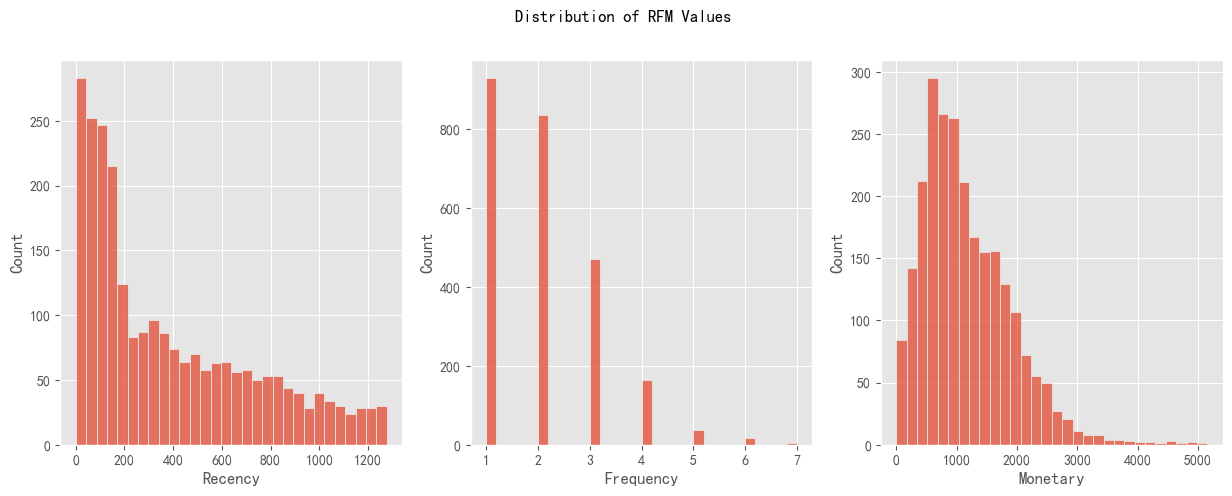

In [10]:
# 查看RFM的分布
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(rfm_df['Recency'], bins=30, ax=ax[0])
sns.histplot(rfm_df['Frequency'], bins=30, ax=ax[1])
sns.histplot(rfm_df['Monetary'], bins=30, ax=ax[2])
plt.suptitle('Distribution of RFM Values')
plt.show()

由以上图可知，R、F和M值的分布都存在右偏，特别是F和M值。直接聚类会被这些异常值主导，因此我们需要进行对数转换，以缓解偏态分布，使其接近正态化。但在对数转换之前需要对R进行反转，使其方向所表达的意义同F和M（即分数越高，代表客户越活跃，越忠诚，越具有价值）。R反装方法为数据集中最大的R值加上1再减去各原始R值。在机器学习之前，还需对数据进行标准化，以消除不同量纲带来的影响。

### 4.2 R值反转处理

In [11]:
# 对原始Recency进行反转，方法为R' = Rmax + 1 - R
# 先找出数据集中最大的Recency值
Recency_max = rfm_df['Recency'].max()
print('数据集中Recency的最大值为：',Recency_max)

数据集中Recency的最大值为： 1276


In [12]:
# 创建反转后的新Recency列
rfm_df['Recency_reverse'] = Recency_max + 1 -rfm_df['Recency']
rfm_df.head()

,Recency,Frequency,Monetary,Recency_reverse
用户ID,,,,
3211111,231,1,590.091338,1046
3211114,67,1,505.748788,1210
3211115,77,2,1008.014778,1200
3211117,106,1,918.527138,1171
3211118,196,1,699.088746,1081


### 4.3 对数转换处理

In [13]:
# 对F和M进行对数变换以缓解偏态分布
rfm_log = rfm_df[['Frequency', 'Monetary']].apply(lambda x: np.log1p(x)) # np.log1p防止log(0)
rfm_log['Recency1'] = rfm_df['Recency_reverse'] # R一般不需要变换

In [14]:
rfm_log.head()

,Frequency,Monetary,Recency1
用户ID,,,
3211111,0.693147,6.381971,1046
3211114,0.693147,6.228015,1210
3211115,1.098612,6.916730,1200
3211117,0.693147,6.823860,1171
3211118,0.693147,6.551207,1081


### 4.4 数据标准化

In [15]:
# 标准化数据 (使均值为0，方差为1，这对于基于距离的K-means算法至关重要)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm_df.index, columns=['Recency1', 'Frequency', 'Monetary'])

In [16]:
rfm_scaled.head()

,Recency1,Frequency,Monetary
用户ID,,,
3211111,-1.097596,-0.580858,0.448728
3211114,-1.097596,-0.780706,0.923762
3211115,0.138808,0.113310,0.894796
3211117,-1.097596,-0.007244,0.810797
3211118,-1.097596,-0.361173,0.550107


肘部法确定K值

### 4.5 确定最佳K值

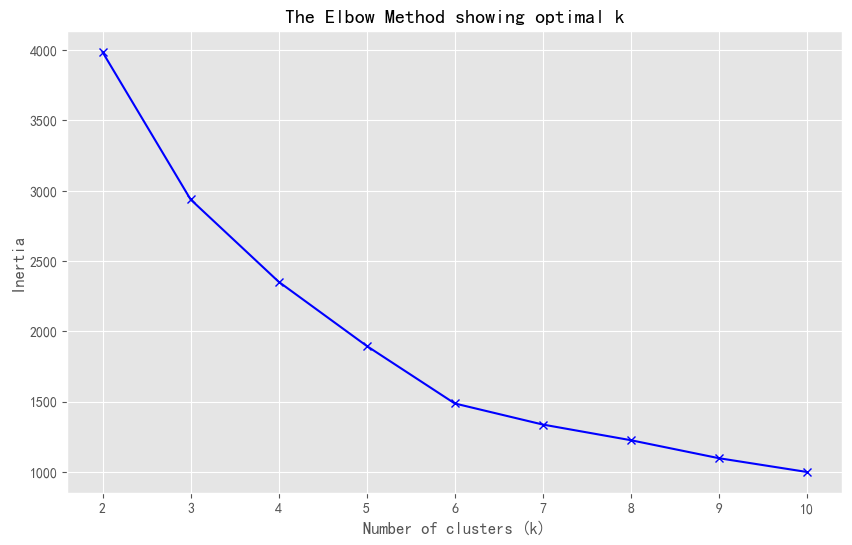

In [17]:
# 定义可能的K值范围
K_range = range(2, 11)
inertias = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_) #  inertia_是样本到其最近聚类中心的平方距离之和

# 绘制肘部法则图
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing optimal k')
plt.show()

轮廓系数法确定K值

For n_clusters = 2, the silhouette score is 0.416
For n_clusters = 3, the silhouette score is 0.405
For n_clusters = 4, the silhouette score is 0.352
For n_clusters = 5, the silhouette score is 0.379
For n_clusters = 6, the silhouette score is 0.399
For n_clusters = 7, the silhouette score is 0.387
For n_clusters = 8, the silhouette score is 0.388
For n_clusters = 9, the silhouette score is 0.374
For n_clusters = 10, the silhouette score is 0.370


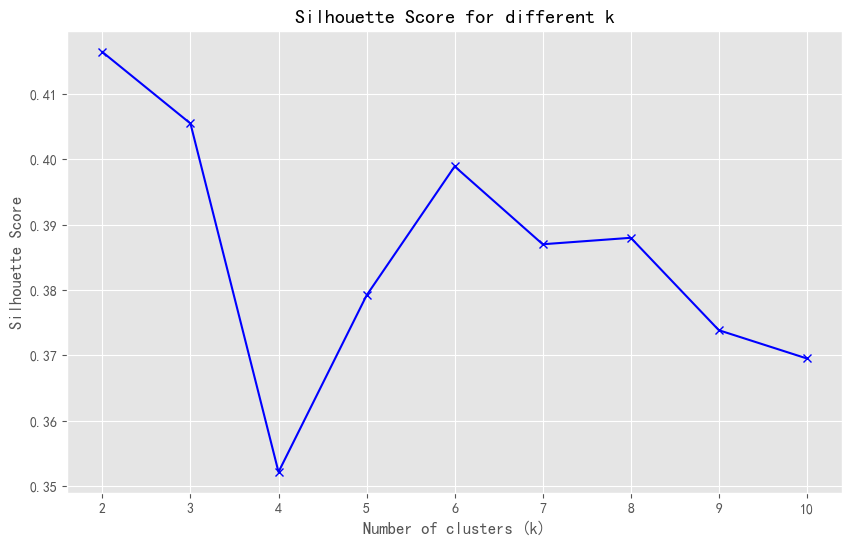

In [18]:
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(rfm_scaled)
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg:.3f}")

# 绘制轮廓系数图
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different k')
plt.show()

K-means聚类最重要的一点就是K指的确定，本次分析采用肘部法和轮廓系数法两种方法综合确定，最终K取值为3。

## 五、进行K-Means聚类

In [19]:
# 使用选择的k值进行最终聚类
chosen_k = 3
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans_final.fit(rfm_scaled)

# 将聚类标签赋给原始RFM dataframe
rfm_df['Cluster'] = kmeans_final.labels_
rfm_scaled['Cluster'] = kmeans_final.labels_

In [20]:
rfm_df.head()

,Recency,Frequency,Monetary,Recency_reverse,Cluster
用户ID,,,,,
3211111,231,1,590.091338,1046,0
3211114,67,1,505.748788,1210,0
3211115,77,2,1008.014778,1200,1
3211117,106,1,918.527138,1171,0
3211118,196,1,699.088746,1081,0


In [21]:
rfm_scaled.head()

,Recency1,Frequency,Monetary,Cluster
用户ID,,,,
3211111,-1.097596,-0.580858,0.448728,0
3211114,-1.097596,-0.780706,0.923762,0
3211115,0.138808,0.113310,0.894796,1
3211117,-1.097596,-0.007244,0.810797,0
3211118,-1.097596,-0.361173,0.550107,0


In [22]:
# 按聚类分组查看RFM均值
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency_reverse': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] # 'count'是每个分组的用户数
}).round(2)

print(cluster_summary)

        Recency_reverse Frequency Monetary      
                   mean      mean     mean count
Cluster                                         
0               1032.92      1.14   553.85   595
1               1061.19      2.78  1654.44  1273
2                384.45      1.32   729.81   594


In [23]:
# 计算聚类中心（标准化后的）
cluster_centers = pd.DataFrame(kmeans_final.cluster_centers_, columns=['Recency1', 'Frequency', 'Monetary'])
cluster_centers['Cluster'] = cluster_centers.index

## 六、结果可视化

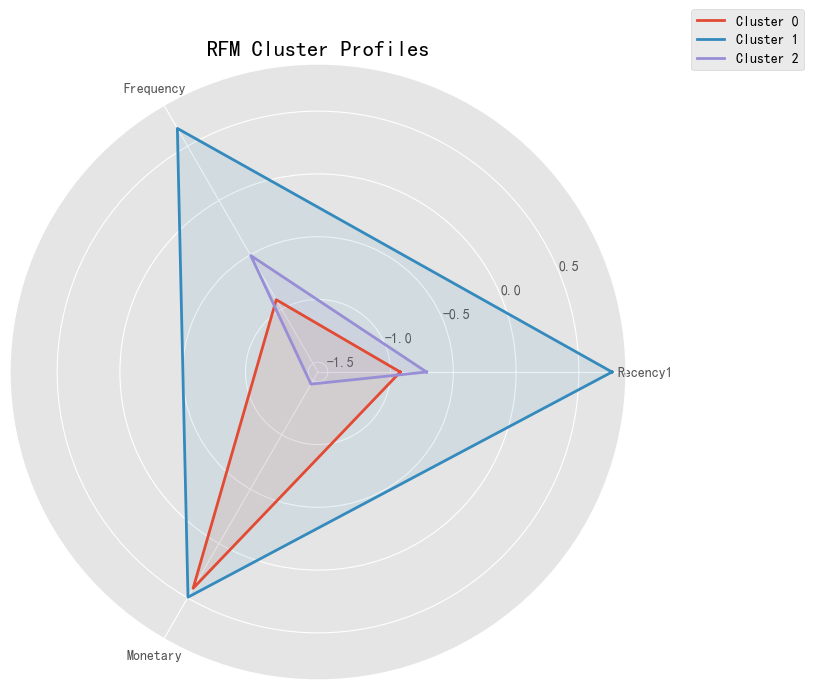

In [24]:
# 绘制雷达图
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

angles = np.linspace(0, 2*np.pi, len(cluster_centers.columns[:-1]), endpoint=False).tolist()
angles += angles[:1] # 闭合雷达图

for i, row in cluster_centers.iterrows():
    values = row.values[:-1].tolist()
    values += values[:1] # 闭合雷达图
    ax.plot(angles, values, label=f'Cluster {i}', linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.1)
# 采用标准化后RFM值画雷达图，三个维度上值越大，表示用户群体越活跃、越忠诚和越有价值
ax.set_thetagrids(np.degrees(angles[:-1]), ['Recency1', 'Frequency', 'Monetary'])
ax.set_title('RFM Cluster Profiles', size=16)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

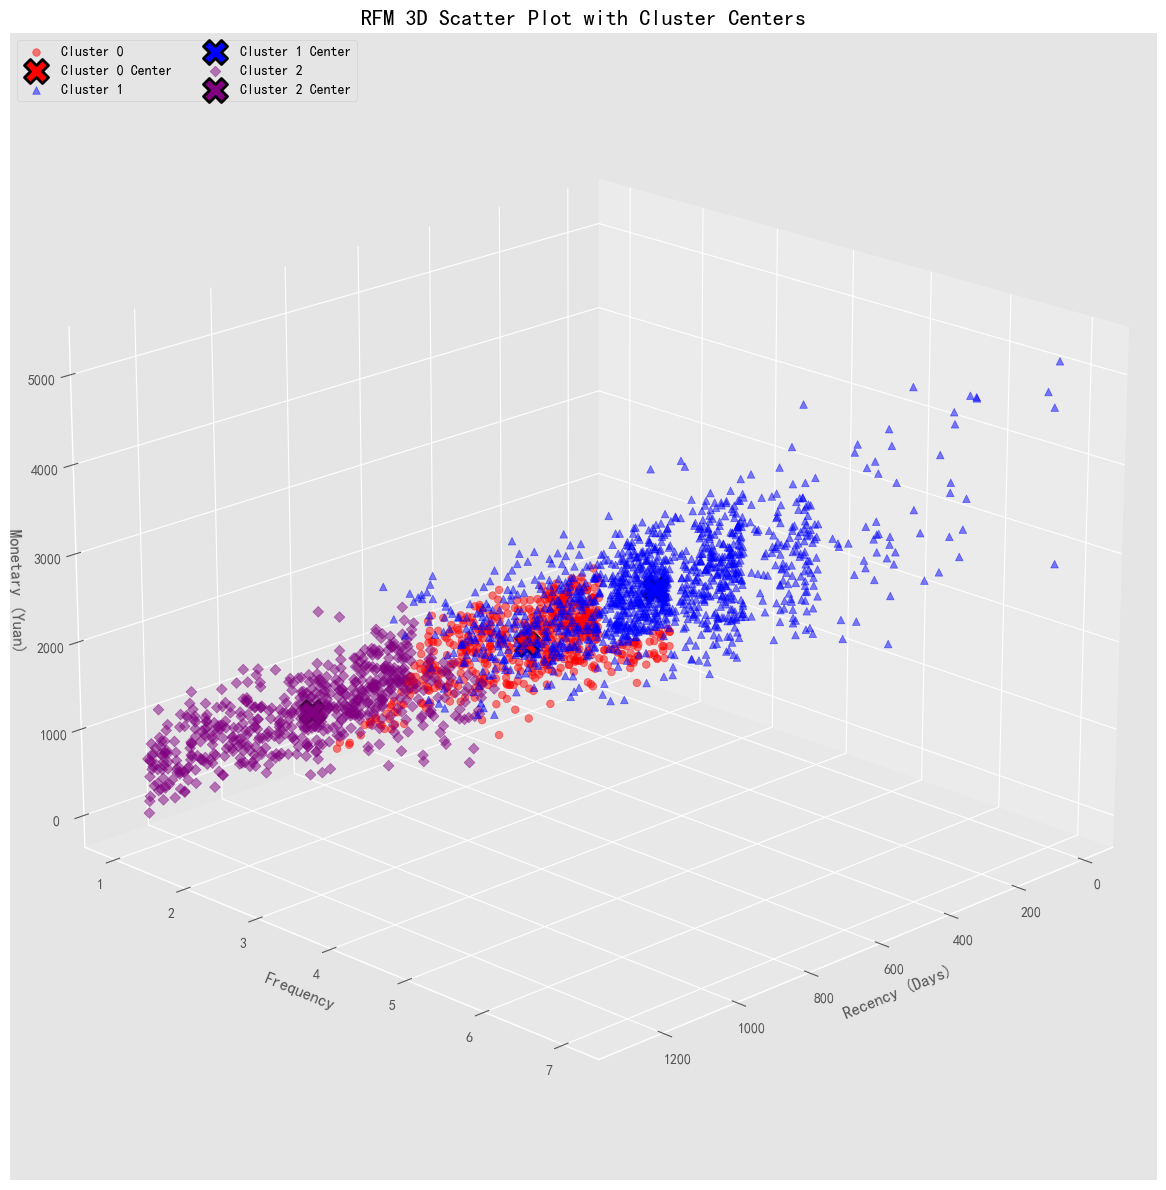

In [25]:
# 计算每个聚类的中心点(采用原始数据)
cluster_centers = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# 创建3D图形
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# 为每个聚类设置不同的颜色和标签
clusters = sorted(rfm_df['Cluster'].unique())
colors = ['red', 'blue', 'purple']
markers = ['o',  '^', 'D']

# 绘制每个聚类的点
for i, cluster in enumerate(clusters):
    cluster_data = rfm_df[rfm_df['Cluster'] == cluster]
    ax.scatter(
        cluster_data['Recency'],
        cluster_data['Frequency'],
        cluster_data['Monetary'],
        c=[colors[i]],
        marker=markers[i % len(markers)],
        label=f'Cluster {cluster}',
        alpha=0.5,
        s=30
    )
    
    # 绘制聚类中心
    center = cluster_centers.loc[cluster]
    ax.scatter(
        center['Recency'],
        center['Frequency'],
        center['Monetary'],
        c=[colors[i]],
        marker='X',
        s=300,  # 较大的点表示中心
        edgecolors='black',
        linewidth=2,
        label=f'Cluster {cluster} Center'
    )

# 设置坐标轴标签
ax.set_xlabel('Recency (Days)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_zlabel('Monetary (Yuan)', fontsize=12)

# 设置标题
ax.set_title('RFM 3D Scatter Plot with Cluster Centers', fontsize=16)

# 添加图例
ax.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2)

# 调整视角
ax.view_init(elev=20, azim=45)

# 添加网格
ax.grid(True)

plt.tight_layout()
plt.show()

## 七、结果分析

由雷达图可知：
Cluster0属于**重要挽回客户**，虽然他们很久没买了，购买频次也低，但是购买金额很高。对该类型客户我们需要分析其过去消费行为，提供极其精准和个性化的推荐或优惠，尝试重新激活。
Cluster1属于**重要价值客户**， R、F、M三项得分均非常高，雷达图是一个接近完美的大三角形，覆盖了绝大部分面积。对该类型客户我们需要重点维护，提供VIP服务，优先推送新品和独家优惠。
Cluster2可能为**新用户**，RFM值都很低，表示刚消费，但频次和金额还不高。需要引导其成为忠诚客户，可以发送欢迎邮件，引导复购，关注首次体验。Cluster2也可能属于**流失客户**，需评估其回流可能性，避免浪费过多营销资源。该群体为新用户还是流失客户，需要根据客户注册时间确定。
由3D散点图可以直观地观察到由原始RFM值绘制的三类客户分布情况。